This notebook contains implementations of various gradient descent optimiztion algorithms.

References:

https://course.fast.ai/

https://sgugger.github.io/sgd-variants.html#sgd-variants


In [0]:
%matplotlib inline
from fastai.basics import *

Download the MNIST data set 

In [2]:
!wget  http://deeplearning.net/data/mnist/mnist.pkl.gz

--2020-01-29 11:31:40--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  6.53MB/s    in 2.4s    

2020-01-29 11:31:42 (6.53 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [3]:
path = Path('./')
path.ls()

[PosixPath('.config'), PosixPath('mnist.pkl.gz'), PosixPath('sample_data')]

In [0]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), (x_test, y_test)) = pickle.load(f, encoding='latin-1')

(50000, 784)

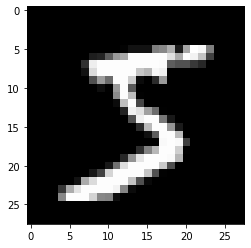

In [5]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [6]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [0]:
class Mnist_NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin1 = nn.Linear(784, 30, bias=True)
    self.lin2 = nn.Linear(30,10,bias=True)
  def forward(self,xb):
    x = self.lin1(xb)
    x = F.relu(x)
    x = self.lin2(x)
    return x

In [0]:
 model = Mnist_NN().cuda()

In [9]:
model

Mnist_NN(
  (lin1): Linear(in_features=784, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=10, bias=True)
)

In [0]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [11]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
lr = 1e-1

In [0]:
loss_func = nn.CrossEntropyLoss()

Vanilla SGD


In [0]:
def update_SGD(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
     
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [0]:
losses_sgd = [update_SGD(x,y,lr) for x,y in data.train_dl]

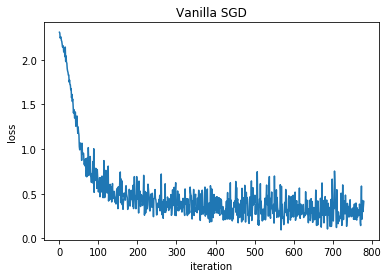

In [16]:
plt.plot(losses_sgd)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Vanilla SGD')
plt.show()

SGD with momentum

In [0]:
def update_SGD_momentum(dl,lr,momentum):
  v = { i:0 for i,p in enumerate(model.parameters())}
  wd = 1e-5
  losses = []
  for x,y in dl:
    y_hat = model(x)
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    loss = loss_func(y_hat,y)
    loss.backward()
    with torch.no_grad():
      for i,p in enumerate(model.parameters()):
        v[i] = momentum*v[i] + lr*p.grad
        p.sub_(v[i])
        p.grad.zero_()
    losses.append(loss.item())
  return losses


In [0]:
model = Mnist_NN().cuda()

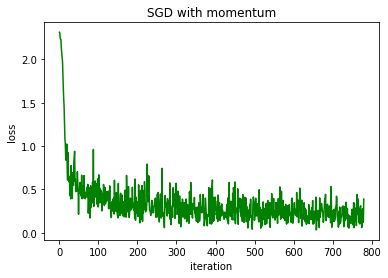

In [19]:
losses_momentum = update_SGD_momentum(data.train_dl,1e-1,0.9)
plt.plot(losses_momentum,'g');
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('SGD with momentum')
plt.show()

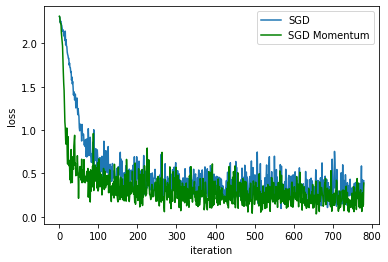

In [20]:
plt.plot(losses_sgd)
plt.plot(losses_momentum,'g')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend(('SGD','SGD Momentum'))
plt.show()

Nesterov

In [0]:
def update_SGD_Nesterov(dl,lr,momentum):
  v = { i:0 for i,p in enumerate(model.parameters())}
  wd = 1e-5
  losses = []
  for x,y in dl:
    
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    p_prev = { i:p for i,p in enumerate(model.parameters())} 
    for i,p in enumerate(model.parameters()):
      p = p - momentum*v[i]
    y_hat = model(x)
    loss = loss_func(y_hat,y)
    loss.backward()
    p_future_grad = { i:p.grad for i,p in enumerate(model.parameters())}
    for i,p in enumerate(model.parameters()):
      p = p_prev[i]
    with torch.no_grad():
      for i,p in enumerate(model.parameters()):
        v[i] = momentum*v[i] + lr*p_future_grad[i]
        p.sub_(v[i])
        p.grad.zero_()
    losses.append(loss.item())
  return losses  

In [0]:
model = Mnist_NN().cuda()

In [0]:
losses_nesterov = update_SGD_Nesterov(data.train_dl,1e-1,0.9)


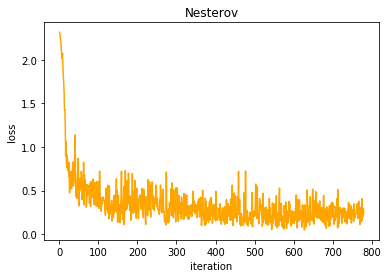

In [24]:
plt.plot(losses_nesterov,'orange');
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Nesterov')
plt.show()

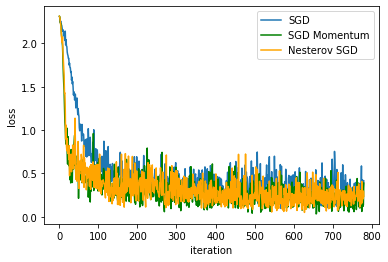

In [25]:
plt.plot(losses_sgd)
plt.plot(losses_momentum,'g')
plt.plot(losses_nesterov,'orange')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend(('SGD','SGD Momentum','Nesterov SGD'))
plt.show()

RMSProp

In [0]:
def update_SGD_rmsprop(dl,lr,beta):
  n = { i:0 for i,p in enumerate(model.parameters())}
  wd = 1e-5
  epsilon = 1e-8
  losses = []
  for x,y in dl:
    y_hat = model(x)
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    loss = loss_func(y_hat,y)
    loss.backward()
    with torch.no_grad():
      for i,p in enumerate(model.parameters()):
        n[i] = beta*n[i] + (1-beta)*p.grad**2
        p.sub_(lr*p.grad/((n[i]+epsilon)**0.5))
        p.grad.zero_()
    losses.append(loss.item())
  return losses

In [0]:
model = Mnist_NN().cuda()

In [0]:
losses_rmsprop = update_SGD_rmsprop(data.train_dl,1e-2,0.9)

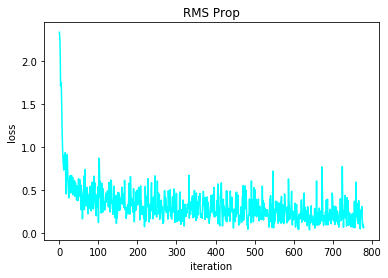

In [29]:
plt.plot(losses_rmsprop,'cyan');
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('RMS Prop')
plt.show()

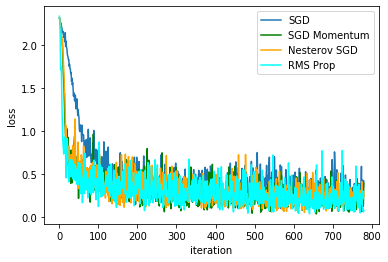

In [30]:
plt.plot(losses_sgd)
plt.plot(losses_momentum,'g')
plt.plot(losses_nesterov,'orange')
plt.plot(losses_rmsprop,'cyan');
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend(('SGD','SGD Momentum','Nesterov SGD','RMS Prop'))
plt.show()

Adam

In [0]:
def update_SGD_Adam(dl,lr,beta1,beta2):
  n = { i:0 for i,p in enumerate(model.parameters())}
  m = { i:0 for i,p in enumerate(model.parameters())}
  wd = 1e-5
  epsilon = 1e-8
  t = 0
  losses = []
  for x,y in dl:
    t += 1 #time
    y_hat = model(x)
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    loss = loss_func(y_hat,y)
    loss.backward()
    with torch.no_grad():
      for i,p in enumerate(model.parameters()):
        m[i] = beta1*m[i] + (1-beta1)*p.grad
        n[i] = beta2*n[i] + (1-beta2)*p.grad**2
        m_hat = m[i]/(1-beta1**t)
        n_hat = n[i]/(1-beta2**t)
        p.sub_(lr*m_hat/(n_hat + epsilon)**0.5)
        p.grad.zero_()
    losses.append(loss.item())
  return losses 

In [0]:
model = model = Mnist_NN().cuda()

In [0]:
losses_Adam = update_SGD_Adam(data.train_dl,1e-2,0.9,0.999)

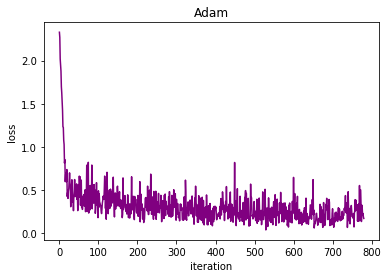

In [34]:
plt.plot(losses_Adam,'purple')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Adam')
plt.show()

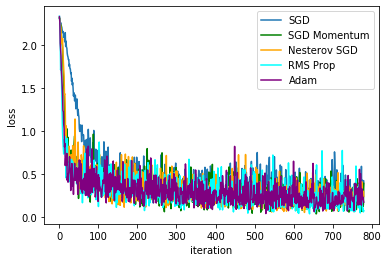

In [35]:
plt.plot(losses_sgd)
plt.plot(losses_momentum,'g')
plt.plot(losses_nesterov,'orange')
plt.plot(losses_rmsprop,'cyan');
plt.plot(losses_Adam,'purple')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend(('SGD','SGD Momentum','Nesterov SGD','RMS Prop','Adam'))
plt.show()